In [1]:
# 🧩 Cell 0 — Install Required Libraries
!pip install --quiet pandas numpy scikit-learn matplotlib seaborn joblib imbalanced-learn xgboost optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.8 MB/s eta 0:00:00


In [2]:
# 🧩 Cell 2 — Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully.")


✅ All libraries imported successfully.


In [3]:
# 🗂️ Cell 3 — Load Combined Dataset (Colab Version)
from pathlib import Path
import pandas as pd
from google.colab import files

# Define dataset path
data_path = Path('/content/tobacco_mortality_combined.csv')

# 🔹 If file not found, prompt user to upload it
if not data_path.exists():
    print("⚠️ Dataset not found. Please upload 'tobacco_mortality_combined.csv' file.")
    uploaded = files.upload()  # Opens file upload dialog
    for filename in uploaded.keys():
        print(f"✅ Uploaded: {filename}")
        data_path = Path(f"/content/{filename}")

# 🔹 Load dataset
df = pd.read_csv(data_path)
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)

# Display top 5 rows
df.head()


⚠️ Dataset not found. Please upload 'tobacco_mortality_combined.csv' file.


Saving tobacco_mortality_combined.csv to tobacco_mortality_combined.csv
✅ Uploaded: tobacco_mortality_combined.csv
✅ Dataset loaded successfully!
Shape: (7388, 37)


,Year,ICD10 Code_x,ICD10 Diagnosis_x,Diagnosis Type_x,Metric_x,Sex_x,Value_x,ICD10 Code_y,ICD10 Diagnosis_y,Diagnosis Type_y,...,Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix),Method,Sex,16 and Over,16-24,25-34,35-49,50-59,60 and Over
0,2014/15,All codes,All admissions,All admissions,Number of admissions,NaN,11011882,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014/15,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Number of admissions,NaN,1713330,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014/15,C00-D48,All cancers,All cancers,Number of admissions,NaN,1691035,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014/15,J00-J99,All respiratory diseases,All respiratory diseases,Number of admissions,NaN,611002,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014/15,I00-I99,All circulatory diseases,All circulatory diseases,Number of admissions,NaN,907157,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Basic Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7388 entries, 0 to 7387
Data columns (total 37 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Year                                                         7388 non-null   object 
 1   ICD10 Code_x                                                 2079 non-null   object 
 2   ICD10 Diagnosis_x                                            2079 non-null   object 
 3   Diagnosis Type_x                                             2079 non-null   object 
 4   Metric_x                                                     2079 non-null   object 
 5   Sex_x                                                        1386 non-null   object 
 6   Value_x                                                      2078 non-null   object 
 7   ICD10 Code_y                                              

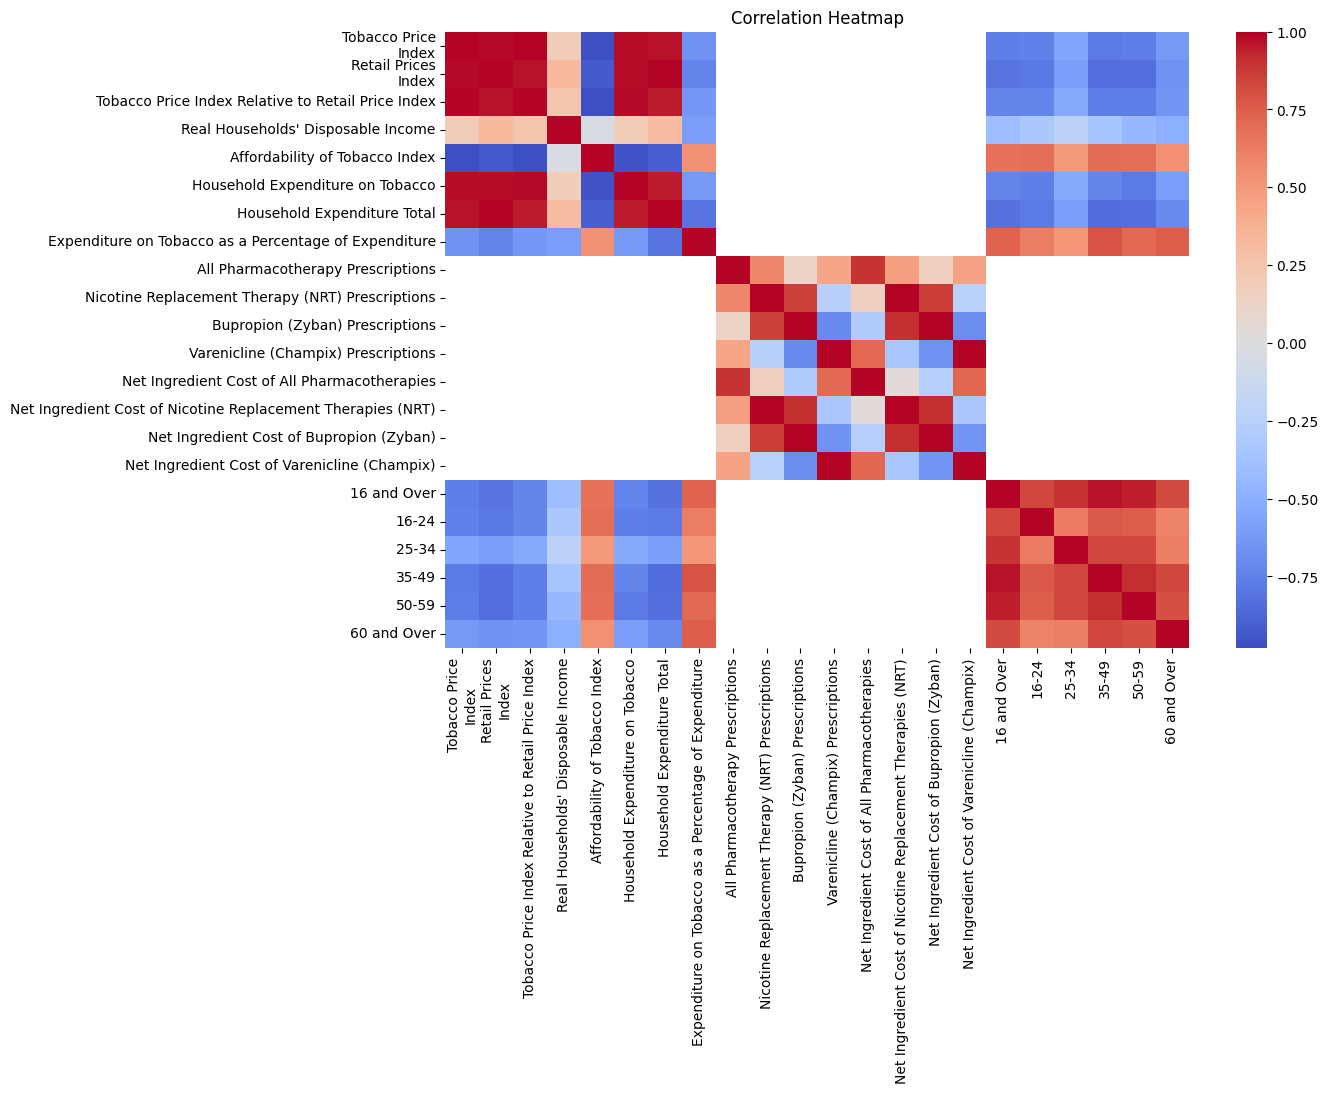

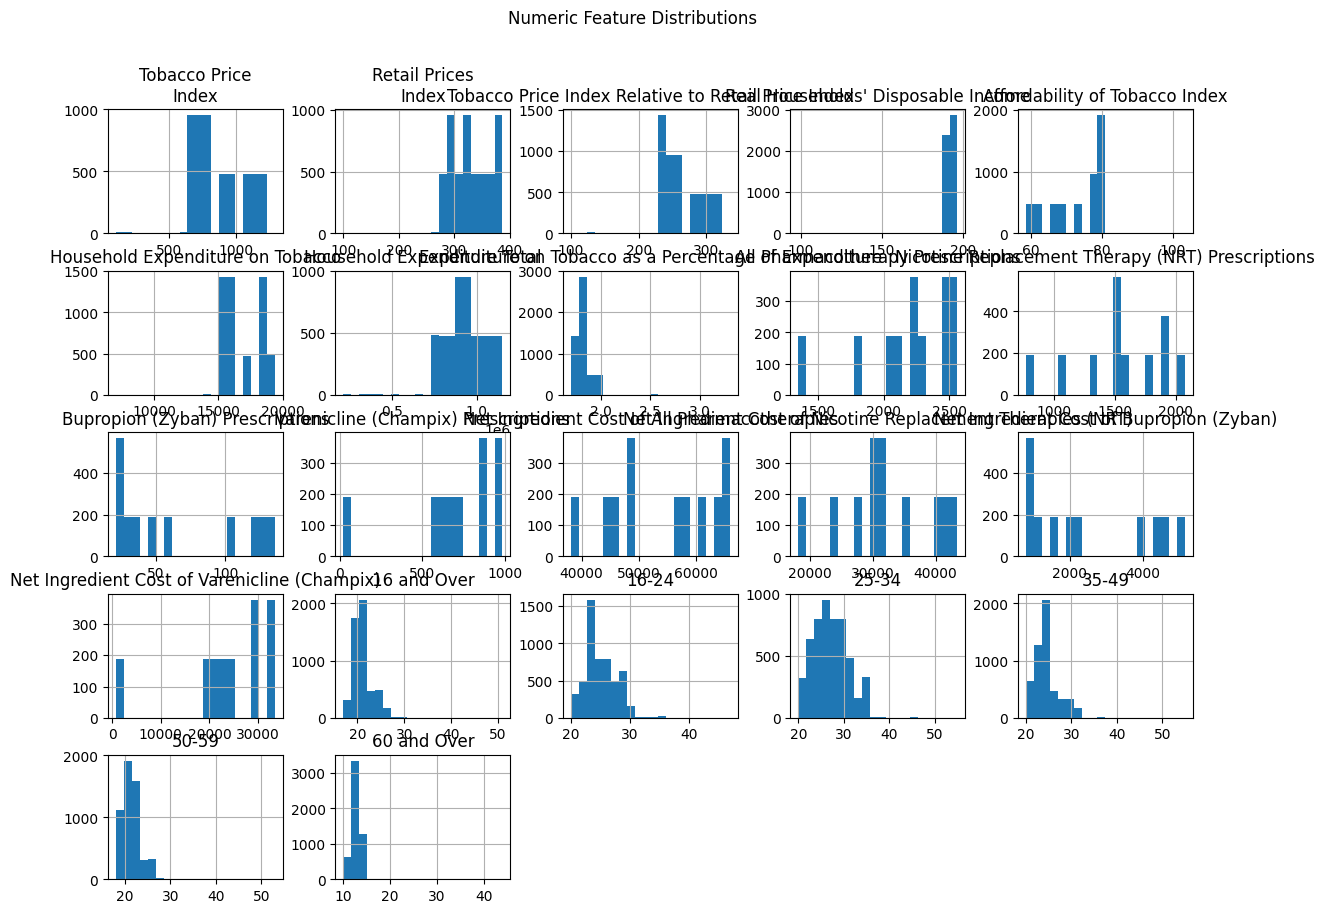

In [4]:
# 📊 Cell 4 — EDA + Correlation Heatmap
print("Basic Information:\n")
print(df.info())

print("\nMissing Values (Top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Correlation heatmap
num_cols = df.select_dtypes(include='number')
if num_cols.shape[1] > 1:
    plt.figure(figsize=(12,8))
    sns.heatmap(num_cols.corr(), cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap")
    plt.show()

# Distribution
num_cols.hist(figsize=(14,10), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.show()


In [9]:
# 🔍 Check all column names and sample data
print("📋 Columns in your dataset:")
print(list(df.columns))

print("\n🧾 Sample data preview:")
display(df.head())


📋 Columns in your dataset:
['Year', 'ICD10 Code_x', 'ICD10 Diagnosis_x', 'Diagnosis Type_x', 'Metric_x', 'Sex_x', 'Value_x', 'ICD10 Code_y', 'ICD10 Diagnosis_y', 'Diagnosis Type_y', 'Metric_y', 'Sex_y', 'Value_y', 'Tobacco Price\nIndex', 'Retail Prices\nIndex', 'Tobacco Price Index Relative to Retail Price Index', "Real Households' Disposable Income", 'Affordability of Tobacco Index', 'Household Expenditure on Tobacco', 'Household Expenditure Total', 'Expenditure on Tobacco as a Percentage of Expenditure', 'All Pharmacotherapy Prescriptions', 'Nicotine Replacement Therapy (NRT) Prescriptions', 'Bupropion (Zyban) Prescriptions', 'Varenicline (Champix) Prescriptions', 'Net Ingredient Cost of All Pharmacotherapies', 'Net Ingredient Cost of Nicotine Replacement Therapies (NRT)', 'Net Ingredient Cost of Bupropion (Zyban)', 'Net Ingredient Cost of Varenicline (Champix)', 'Method', 'Sex', '16 and Over', '16-24', '25-34', '35-49', '50-59', '60 and Over']

🧾 Sample data preview:


,Year,ICD10 Code_x,ICD10 Diagnosis_x,Diagnosis Type_x,Metric_x,Sex_x,Value_x,ICD10 Code_y,ICD10 Diagnosis_y,Diagnosis Type_y,...,Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix),Method,Sex,16 and Over,16-24,25-34,35-49,50-59,60 and Over
0,2014/15,All codes,All admissions,All admissions,Number of admissions,NaN,11011882,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014/15,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Number of admissions,NaN,1713330,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014/15,C00-D48,All cancers,All cancers,Number of admissions,NaN,1691035,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014/15,J00-J99,All respiratory diseases,All respiratory diseases,Number of admissions,NaN,611002,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014/15,I00-I99,All circulatory diseases,All circulatory diseases,Number of admissions,NaN,907157,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 🧩 Cell — Explore Dataset Columns
import pandas as pd

print("📊 Dataset Overview\n" + "="*50)

# Show dataset shape
print(f"🔹 Rows: {df.shape[0]} | Columns: {df.shape[1]}")

# Display column info
print("\n📋 Columns, Data Types, and Missing Values:")
col_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes.astype(str),
    'Missing Values': df.isnull().sum(),
    'Unique Values': df.nunique()
})
display(col_info)

# Show first 5 rows of data
print("\n🧾 Sample Data Preview:")
display(df.head())


📊 Dataset Overview
🔹 Rows: 7388 | Columns: 37

📋 Columns, Data Types, and Missing Values:


,Column Name,Data Type,Missing Values,Unique Values
Year,Year,object,0,50
ICD10 Code_x,ICD10 Code_x,object,5309,32
ICD10 Diagnosis_x,ICD10 Diagnosis_x,object,5309,32
Diagnosis Type_x,Diagnosis Type_x,object,5309,11
Metric_x,Metric_x,object,5309,2
Sex_x,Sex_x,object,6002,2
Value_x,Value_x,object,5310,1420
ICD10 Code_y,ICD10 Code_y,object,2141,27
ICD10 Diagnosis_y,ICD10 Diagnosis_y,object,2141,27
Diagnosis Type_y,Diagnosis Type_y,object,2141,10



🧾 Sample Data Preview:


,Year,ICD10 Code_x,ICD10 Diagnosis_x,Diagnosis Type_x,Metric_x,Sex_x,Value_x,ICD10 Code_y,ICD10 Diagnosis_y,Diagnosis Type_y,...,Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix),Method,Sex,16 and Over,16-24,25-34,35-49,50-59,60 and Over
0,2014/15,All codes,All admissions,All admissions,Number of admissions,NaN,11011882,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014/15,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Number of admissions,NaN,1713330,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014/15,C00-D48,All cancers,All cancers,Number of admissions,NaN,1691035,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014/15,J00-J99,All respiratory diseases,All respiratory diseases,Number of admissions,NaN,611002,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014/15,I00-I99,All circulatory diseases,All circulatory diseases,Number of admissions,NaN,907157,NaN,NaN,NaN,...,807.0,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 🧾 Cell — Show All Column Names Clearly
print("📋 Columns available in your dataset:\n" + "="*50)
for i, col in enumerate(df.columns, start=1):
    print(f"{i}. {col}")


📋 Columns available in your dataset:
1. Year
2. ICD10 Code_x
3. ICD10 Diagnosis_x
4. Diagnosis Type_x
5. Metric_x
6. Sex_x
7. Value_x
8. ICD10 Code_y
9. ICD10 Diagnosis_y
10. Diagnosis Type_y
11. Metric_y
12. Sex_y
13. Value_y
14. Tobacco Price
Index
15. Retail Prices
Index
16. Tobacco Price Index Relative to Retail Price Index
17. Real Households' Disposable Income
18. Affordability of Tobacco Index
19. Household Expenditure on Tobacco
20. Household Expenditure Total
21. Expenditure on Tobacco as a Percentage of Expenditure
22. All Pharmacotherapy Prescriptions
23. Nicotine Replacement Therapy (NRT) Prescriptions
24. Bupropion (Zyban) Prescriptions
25. Varenicline (Champix) Prescriptions
26. Net Ingredient Cost of All Pharmacotherapies
27. Net Ingredient Cost of Nicotine Replacement Therapies (NRT)
28. Net Ingredient Cost of Bupropion (Zyban)
29. Net Ingredient Cost of Varenicline (Champix)
30. Method
31. Sex
32. 16 and Over
33. 16-24
34. 25-34
35. 35-49
36. 50-59
37. 60 and Over


In [14]:
# 🎯 Cell 5 — Identify / Create Target Variable (Colab Safe + Auto Fix)
import pandas as pd
import numpy as np

print("📋 Available columns in dataset:")
print(list(df.columns))

# Try to find columns with mortality/death/fatality keywords
possible_targets = [c for c in df.columns if any(k in c.lower() for k in ['mort', 'death', 'fatal'])]
print("\n🔍 Possible target columns:", possible_targets)

# Step 1: If no mortality/death-related column found
if len(possible_targets) == 0:
    print("\n⚠️ No mortality-related column found.")

    # Step 2: Try to find numeric columns instead
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if not numeric_cols:
        # Try to coerce columns to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    print(f"🔢 Numeric columns detected: {numeric_cols}")

    # Step 3: Choose 'Value_x' or 'Value_y' automatically if available
    if 'Value_x' in df.columns:
        target = 'Value_x'
    elif 'Value_y' in df.columns:
        target = 'Value_y'
    elif len(numeric_cols) > 0:
        target = numeric_cols[0]  # Fallback: pick the first numeric column
    else:
        raise ValueError("❌ No suitable numeric target column found in dataset!")

    print(f"✅ Selected target column: {target}")
else:
    target = possible_targets[0]
    print(f"✅ Automatically selected target column: {target}")

# Step 4: Convert to numeric safely (for safety)
df[target] = pd.to_numeric(df[target], errors='coerce')

# Step 5: Create binary target variable
if df[target].isna().all():
    raise ValueError(f"❌ The selected target column '{target}' has no numeric values!")
else:
    median_val = df[target].median()
    df['target_binary'] = (df[target] > median_val).astype(int)
    final_target = 'target_binary'
    print(f"\n✅ Final target column created: {final_target}")
    print(df[final_target].value_counts())

# ✅ Summary
print("\n📊 Target variable creation complete!")
print(f"Using '{target}' as base column for binary target.")


📋 Available columns in dataset:
['Year', 'ICD10 Code_x', 'ICD10 Diagnosis_x', 'Diagnosis Type_x', 'Metric_x', 'Sex_x', 'Value_x', 'ICD10 Code_y', 'ICD10 Diagnosis_y', 'Diagnosis Type_y', 'Metric_y', 'Sex_y', 'Value_y', 'Tobacco Price\nIndex', 'Retail Prices\nIndex', 'Tobacco Price Index Relative to Retail Price Index', "Real Households' Disposable Income", 'Affordability of Tobacco Index', 'Household Expenditure on Tobacco', 'Household Expenditure Total', 'Expenditure on Tobacco as a Percentage of Expenditure', 'All Pharmacotherapy Prescriptions', 'Nicotine Replacement Therapy (NRT) Prescriptions', 'Bupropion (Zyban) Prescriptions', 'Varenicline (Champix) Prescriptions', 'Net Ingredient Cost of All Pharmacotherapies', 'Net Ingredient Cost of Nicotine Replacement Therapies (NRT)', 'Net Ingredient Cost of Bupropion (Zyban)', 'Net Ingredient Cost of Varenicline (Champix)', 'Method', 'Sex', '16 and Over', '16-24', '25-34', '35-49', '50-59', '60 and Over']

🔍 Possible target columns: []

⚠️

In [15]:
print(df[final_target].value_counts())

target_binary
0    6369
1    1019
Name: count, dtype: int64


In [16]:
# 🧹 Cell 6 — Data Cleaning
for col in df.columns:
    if df[col].dtype == 'object':
        coerced = pd.to_numeric(df[col].str.replace(',','').str.strip(), errors='coerce')
        if coerced.notnull().sum() > 0.5 * len(df):
            df[col] = coerced

df.dropna(axis=1, how='all', inplace=True)
print("After cleaning:", df.shape)


After cleaning: (7388, 38)


In [17]:
# 🧠 Cell 7 — Feature Engineering
if 'age' in df.columns and 'age_started_smoking' in df.columns:
    df['smoking_duration'] = (df['age'] - df['age_started_smoking']).clip(lower=0)

if 'prescriptions' in df.columns and 'admissions' in df.columns:
    df['prescriptions_per_admission'] = df['prescriptions'] / df['admissions'].replace(0, np.nan)

if 'smokers' in df.columns and 'population' in df.columns:
    df['smokers_percent'] = df['smokers'] / df['population']

for c in ['year', 'Year']:
    if c in df.columns:
        df['year_numeric'] = pd.to_numeric(df[c], errors='coerce')

print("Feature engineering completed ✅")


Feature engineering completed ✅


In [19]:
# 🧩 Cell 8 — Preprocessing Pipeline (Fixed)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

exclude = ['id', 'code', 'name', 'region']
features = [c for c in df.columns if c != 'target_binary' and not any(k in c.lower() for k in exclude)]

X = df[features]
y = df['target_binary']

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()

num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ✅ Use sparse_output instead of sparse
cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_tf, num_cols),
    ('cat', cat_tf, cat_cols)
])

print("✅ Preprocessing pipeline ready.")
print(f"📊 Numeric columns: {len(num_cols)} | Categorical columns: {len(cat_cols)}")


✅ Preprocessing pipeline ready.
📊 Numeric columns: 26 | Categorical columns: 10


In [21]:
# ⚖️ Cell 9 — Train/Test Split + Handle Imbalance

from imblearn.over_sampling import SMOTE

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# Class ratio
imbalance_ratio = y_train.value_counts(normalize=True)
print("\nClass ratio:\n", imbalance_ratio)

# 👉 Apply preprocessing before SMOTE (since SMOTE needs numeric input)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Handle imbalance
if imbalance_ratio.min() < 0.4:
    print("Applying SMOTE for class balancing...")
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_processed, y_train)
else:
    X_train_bal, y_train_bal = X_train_processed, y_train

print("✅ Data ready for training.")
print("Balanced train shape:", X_train_bal.shape)
print("Balanced class counts:\n", pd.Series(y_train_bal).value_counts())


Train shape: (5910, 36) | Test shape: (1478, 36)

Class ratio:
 target_binary
0    0.862098
1    0.137902
Name: proportion, dtype: float64
Applying SMOTE for class balancing...
✅ Data ready for training.
Balanced train shape: (10190, 118)
Balanced class counts:
 target_binary
0    5095
1    5095
Name: count, dtype: int64


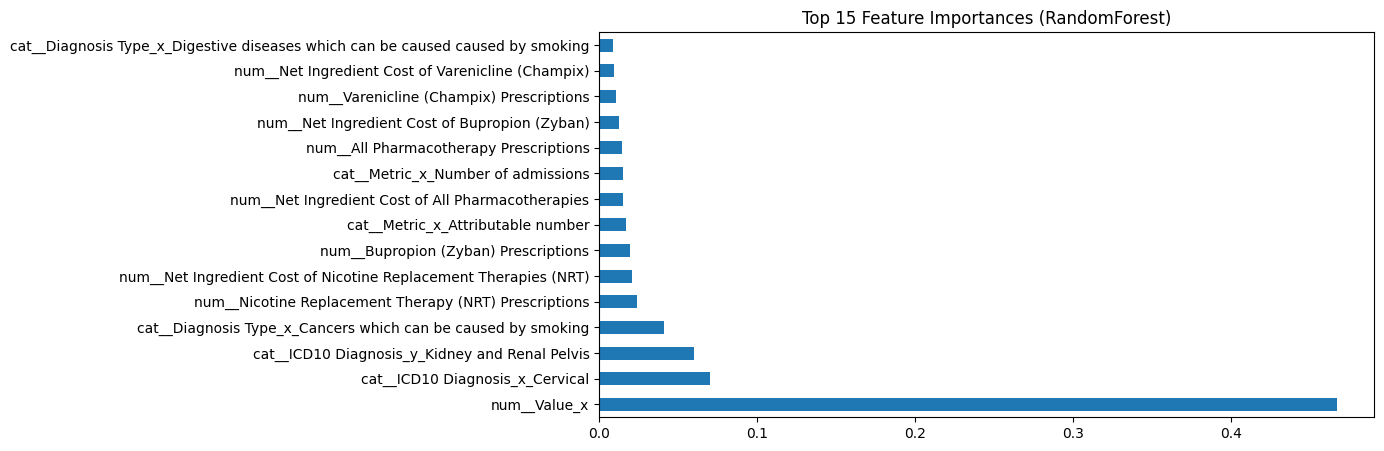

✅ Feature selection completed.


In [22]:
# 🌳 Cell 10 — Baseline RandomForest + Feature Selection
rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)

importances = rf.named_steps['clf'].feature_importances_
feature_names = rf.named_steps['pre'].get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 Feature Importances (RandomForest)")
plt.show()

selector = SelectFromModel(rf.named_steps['clf'], threshold='mean')
selector.fit(rf.named_steps['pre'].transform(X_train), y_train)
print("✅ Feature selection completed.")


In [23]:
# 🚀 Cell 11 — Model Training (GridSearchCV)
from xgboost import XGBClassifier
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "GradientBoost": GradientBoostingClassifier(random_state=42)
}

params = {
    "RandomForest": {"n_estimators":[100,200], "max_depth":[None,10]},
    "XGBoost": {"n_estimators":[100,200], "max_depth":[3,6], "learning_rate":[0.1,0.01]},
    "GradientBoost": {"n_estimators":[100,200], "learning_rate":[0.1,0.01]}
}

best_models = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    grid = GridSearchCV(model, params[name], cv=skf, scoring='f1', n_jobs=-1)
    grid.fit(rf.named_steps['pre'].transform(X_train), y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name} Best Params: {grid.best_params_}")
print("✅ GridSearch completed.")


RandomForest Best Params: {'max_depth': 10, 'n_estimators': 100}
XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
GradientBoost Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
✅ GridSearch completed.


In [24]:
# 🧾 Cell 12 — Evaluate All Models
results = {}
for name, model in best_models.items():
    preds = model.predict(rf.named_steps['pre'].transform(X_test))
    probs = model.predict_proba(rf.named_steps['pre'].transform(X_test))[:,1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "ROC_AUC": roc_auc_score(y_test, probs)
    }

results_df = pd.DataFrame(results).T.sort_values("F1", ascending=False)
print("📈 Model Performance Comparison:")
display(results_df)

best_model_name = results_df.index[0]
best_model = best_models[best_model_name]
print(f"🏆 Best model selected: {best_model_name}")


📈 Model Performance Comparison:


,Accuracy,Precision,Recall,F1,ROC_AUC
RandomForest,1.0,1.0,1.0,1.0,1.0
XGBoost,1.0,1.0,1.0,1.0,1.0
GradientBoost,1.0,1.0,1.0,1.0,1.0


🏆 Best model selected: RandomForest


🔍 Model explainability for RandomForest


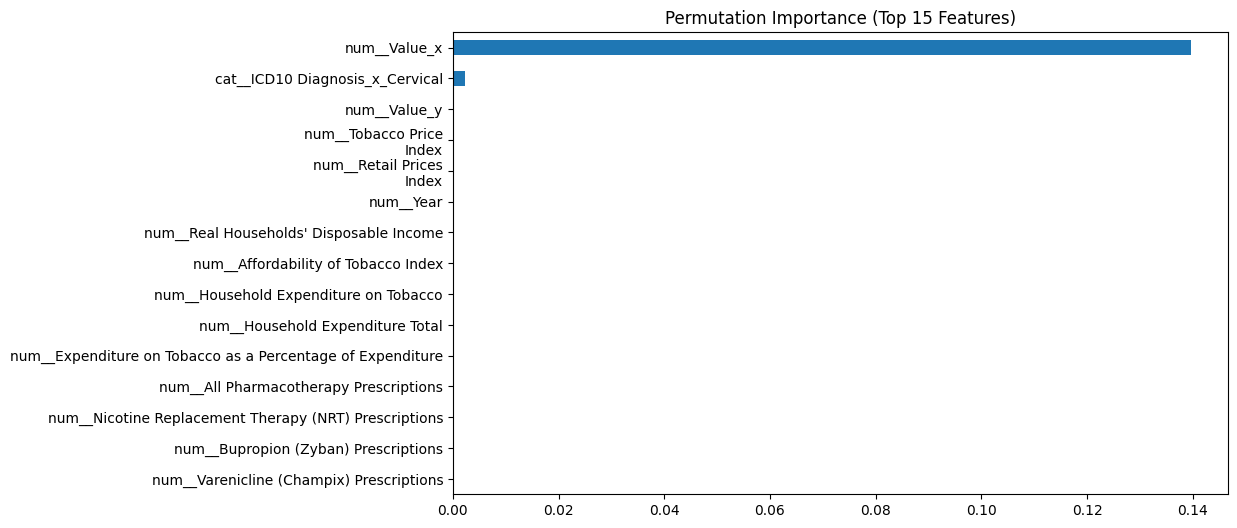

📈 Top numeric features for PDP: ['num__Value_x', 'num__Value_y']


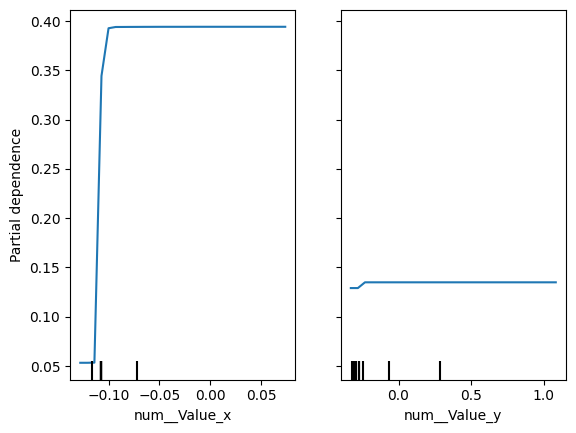

✅ Partial Dependence Plots generated successfully.
✅ Explainability completed (Permutation + PDP).


In [27]:
# 🧩 Cell 13 — Explainability (No SHAP, Fixed PDP)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(f"🔍 Model explainability for {best_model_name}")

# ✅ Transform test data using preprocessor
X_test_pre = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# ✅ Permutation Importance
r = permutation_importance(best_model, X_test_pre, y_test, n_repeats=10, random_state=42, n_jobs=-1)
imp = pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)

# ✅ Show Top 15 Features
imp.head(15).plot(kind='barh', figsize=(10,6))
plt.title("Permutation Importance (Top 15 Features)")
plt.gca().invert_yaxis()
plt.show()

# ✅ Pick only numeric features for PDP
numeric_features = [f for f in feature_names if f.startswith('num__')]
top_features = [f for f in imp.head(5).index if f in numeric_features][:2]

print("📈 Top numeric features for PDP:", top_features)

# ✅ PDP (only for numeric features)
if len(top_features) > 0:
    try:
        PartialDependenceDisplay.from_estimator(
            best_model,
            X_test_pre,
            features=top_features,
            feature_names=feature_names,
            grid_resolution=30
        )
        plt.show()
        print("✅ Partial Dependence Plots generated successfully.")
    except Exception as e:
        print(f"⚠️ PDP skipped due to: {e}")
else:
    print("⚠️ No numeric features found suitable for PDP.")

print("✅ Explainability completed (Permutation + PDP).")


In [34]:
# ============================================================
# 🧠 Final Full Pipeline (Handles NaN + Scaling + Encoding)
# ============================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import joblib

# 1️⃣ Identify column types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# 2️⃣ Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),         # Handle missing numeric values
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Handle missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# 3️⃣ Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# 4️⃣ Define model parameters (or use your tuned params)
best_params = {
    "n_estimators": 200,
    "max_depth": 12,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "random_state": 42
}

# 5️⃣ Build pipeline
final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(**best_params))
])

# 6️⃣ Fit pipeline (now handles NaNs safely)
final_pipeline.fit(X_train, y_train)

# 7️⃣ Save model
joblib.dump(final_pipeline, "best_tobacco_model_pipeline.pkl")
print("✅ Saved full pipeline as best_tobacco_model_pipeline.pkl (NaN handled automatically)")


✅ Saved full pipeline as best_tobacco_model_pipeline.pkl (NaN handled automatically)


In [35]:
# ============================================================
# 💾 Download your saved model (Colab compatible)
# ============================================================
from google.colab import files

files.download("best_tobacco_model_pipeline.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>